In [23]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [24]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# Data Exploration

In [2]:
DATA_PATH = os.path.join(os.getcwd(), "data")

In [3]:
def load_tweet_data(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "train.csv")
    return pd.read_csv(csv_path)

In [4]:
tweet_raw_data = load_tweet_data()

In [5]:
tweet_raw_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
tweet_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
tweet_raw_data["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [13]:
tweet_prototype_data = tweet_raw_data.copy()

In [14]:
tweet_prototype_data["p_keyword"] = tweet_prototype_data["keyword"].apply(lambda x: x if not pd.isnull(x) else '0')
tweet_prototype_data["p_location"] = tweet_prototype_data["location"].apply(lambda x: x if not pd.isnull(x) else '0')
tweet_prototype_data["p_has_location"] = tweet_prototype_data["location"].apply(lambda x: 1 if not pd.isnull(x) else 0)

tweet_prototype_data = tweet_prototype_data.drop(['keyword', 'location'], axis=1)

In [15]:
tweet_prototype_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              7613 non-null   int64 
 1   text            7613 non-null   object
 2   target          7613 non-null   int64 
 3   p_keyword       7613 non-null   object
 4   p_location      7613 non-null   object
 5   p_has_location  7613 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 357.0+ KB


In [16]:
tweet_keyword_dict = tweet_prototype_data["p_keyword"].value_counts().to_dict()
tweet_keyword_dict

{'0': 61,
 'fatalities': 45,
 'deluge': 42,
 'armageddon': 42,
 'sinking': 41,
 'damage': 41,
 'harm': 41,
 'body%20bags': 41,
 'evacuate': 40,
 'fear': 40,
 'outbreak': 40,
 'siren': 40,
 'twister': 40,
 'windstorm': 40,
 'collided': 40,
 'sinkhole': 39,
 'sunk': 39,
 'hellfire': 39,
 'weapon': 39,
 'weapons': 39,
 'famine': 39,
 'explosion': 39,
 'whirlwind': 39,
 'earthquake': 39,
 'derailment': 39,
 'wreckage': 39,
 'collision': 39,
 'flames': 39,
 'wrecked': 39,
 'ambulance': 38,
 'injury': 38,
 'hurricane': 38,
 'flooding': 38,
 'fire': 38,
 'fatal': 38,
 'blaze': 38,
 'explode': 38,
 'drowned': 38,
 'thunder': 38,
 'derailed': 38,
 'typhoon': 38,
 'deaths': 38,
 'upheaval': 38,
 'oil%20spill': 38,
 'bombed': 38,
 'emergency': 37,
 'pandemonium': 37,
 'hostages': 37,
 'wounded': 37,
 'debris': 37,
 'ruin': 37,
 'burning%20buildings': 37,
 'sandstorm': 37,
 'wreck': 37,
 'blizzard': 37,
 'curfew': 37,
 'crush': 37,
 'fatality': 37,
 'bioterror': 37,
 'mudslide': 37,
 'quarantined'

In [21]:
tweet_location_dict = tweet_prototype_data["p_location"].value_counts().to_dict()
# tweet_location_dict

In [18]:
tweet_prototype_data["p_has_location"].value_counts()

1    5080
0    2533
Name: p_has_location, dtype: int64

In [109]:
tweet_prototype_data.to_csv('./data/tweet_processed.csv')

## Prototype 0
Drop `p_location`, `p_keyword`, and `p_has_location`.  
Only consider `text` and `target`.

In [25]:
tweet_data0 = tweet_prototype_data.copy()
tweet_data0 = tweet_data0.drop(['p_location', 'p_keyword', 'p_has_location'], axis=1)

In [41]:
tweet_data0 = tweet_data0.drop(['id'], axis=1)

In [42]:
tweet_data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


## Prototype 1
Drop `p_location`. 

In [20]:
tweet_data1 = tweet_prototype_data.copy()
tweet_data1 = tweet_data1.drop(['p_location'], axis=1)

# Data Preparation

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

In [48]:
from collections import Counter

## Prototype 0

In [45]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=84)
for train_index, test_index in split.split(tweet_data0, tweet_data0["target"]):
    train_set0 = tweet_data0.loc[train_index]
    test_and_valid_set0 = tweet_data0.loc[test_index]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=84)
for test_index, valid_index in split2.split(test_and_valid_set0, test_and_valid_set0["target"]):
    test_set0 = tweet_data0.loc[test_index]
    valid_set0 = tweet_data0.loc[valid_index]


In [46]:
print("train dataset:", len(train_set0))
print("valid dataset:", len(valid_set0))
print("test dataset:", len(test_set0))

train dataset: 4567
valid dataset: 1523
test dataset: 1523


In [84]:
train_dataset0 = tf.data.Dataset.from_tensor_slices((train_set0['text'].values, train_set0['target'].values))
valid_dataset0 = tf.data.Dataset.from_tensor_slices((valid_set0['text'].values, valid_set0['target'].values))
test_dataset0 = tf.data.Dataset.from_tensor_slices((test_set0['text'].values, test_set0['target'].values))

In [85]:
BUFFER_SIZE = 10000
BATCH_SIZE = 25

In [86]:
train_dataset0 = train_dataset0.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_dataset0 = valid_dataset0.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [87]:
for example, label in train_dataset0.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('targets: ', label.numpy()[:3])

texts:  [b'Another sad ocean casualty-Gray whale population in the Pacific listed as critically #endangered (#drone video) https://t.co/vwz3vZpmfb .'
 b"@AnnmarieRonan @niamhosullivanx I can't watch tat show its like a horror movie to me I get flashbacks an everything #traumatised"
 b"Crazy storm hit and I'm trapped inside a Hobby Lobby AMA http://t.co/8qc8Bcxoko"]

targets:  [1 0 1]


2023-08-19 10:57:11.290930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [4567]
	 [[{{node Placeholder/_1}}]]
2023-08-19 10:57:11.292776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4567]
	 [[{{node Placeholder/_0}}]]


### Text Encoding

In [88]:
VOCAB_SIZE = 5000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset0.map(lambda text, label: text))

2023-08-19 10:57:24.920235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [4567]
	 [[{{node Placeholder/_1}}]]
2023-08-19 10:57:24.921324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4567]
	 [[{{node Placeholder/_0}}]]


In [89]:
vocab = np.array(encoder.get_vocabulary())
print(vocab.size)
vocab[:20]

5000


array(['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is', 'for',
       'on', 'you', 'my', 'with', 'that', 'it', 'at', 'by', 'this'],
      dtype='<U21')

In [90]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 159,  837, 1516,    1,    1, 1100,    4,    2, 2651, 3914,   25,
           1, 4289, 1812,   70,    1,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   1,    1,    8,  109,  130,    1,  527,   39,   27,    3,  716,
         279,    5,   26,    8,   48,    1,   42,  768,  439,    0,    0,
           0,    0],
       [ 877,   91,  210,    7,   36,  245,  539,    3,    1,    1,    1,
           1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]])

In [91]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Another sad ocean casualty-Gray whale population in the Pacific listed as critically #endangered (#drone video) https://t.co/vwz3vZpmfb .'
Round-trip:  another sad ocean [UNK] [UNK] population in the pacific listed as [UNK] endangered drone video [UNK]        

Original:  b"@AnnmarieRonan @niamhosullivanx I can't watch tat show its like a horror movie to me I get flashbacks an everything #traumatised"
Round-trip:  [UNK] [UNK] i cant watch [UNK] show its like a horror movie to me i get [UNK] an everything traumatised    

Original:  b"Crazy storm hit and I'm trapped inside a Hobby Lobby AMA http://t.co/8qc8Bcxoko"
Round-trip:  crazy storm hit and im trapped inside a [UNK] [UNK] [UNK] [UNK]            



# Model and Training

## Prototype 0

### Create the Model

In [92]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence length
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [93]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          320000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 394,369
Trainable params: 394,369
Non-tr

In [80]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [94]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train the Model

In [95]:
history = model.fit(train_dataset0, epochs=10,
                    validation_data=valid_dataset0,
                    validation_steps=30)

Epoch 1/10


2023-08-19 10:58:09.615464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4567]
	 [[{{node Placeholder/_0}}]]
2023-08-19 10:58:09.616705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4567]
	 [[{{node Placeholder/_0}}]]


2023-08-19 10:58:20.298904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-08-19 10:58:31.588032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


183/183 [==============================] - ETA: 0s - loss: 0.6820 - accuracy: 0.5704

2023-08-19 10:59:01.833749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1523]
	 [[{{node Placeholder/_1}}]]


183/183 [==============================] - 63s 193ms/step - loss: 0.6820 - accuracy: 0.5704 - val_loss: 0.6518 - val_accuracy: 0.6067
Epoch 2/10
183/183 [==============================] - 23s 124ms/step - loss: 0.5858 - accuracy: 0.6265 - val_loss: 0.4829 - val_accuracy: 0.7693
Epoch 3/10
183/183 [==============================] - 43s 232ms/step - loss: 0.4262 - accuracy: 0.8115 - val_loss: 0.3982 - val_accuracy: 0.8253
Epoch 4/10
183/183 [==============================] - 23s 124ms/step - loss: 0.3369 - accuracy: 0.8564 - val_loss: 0.3540 - val_accuracy: 0.8560
Epoch 5/10
183/183 [==============================] - 25s 136ms/step - loss: 0.2746 - accuracy: 0.8850 - val_loss: 0.3276 - val_accuracy: 0.8747
Epoch 6/10
183/183 [==============================] - 25s 132ms/step - loss: 0.2309 - accuracy: 0.9078 - val_loss: 0.3267 - val_accuracy: 0.8813
Epoch 7/10
183/183 [==============================] - 24s 128ms/step - loss: 0.1912 - accuracy: 0.9295 - val_loss: 0.3595 - val_accuracy: 0.8

(0.0, 0.7096784234046936)

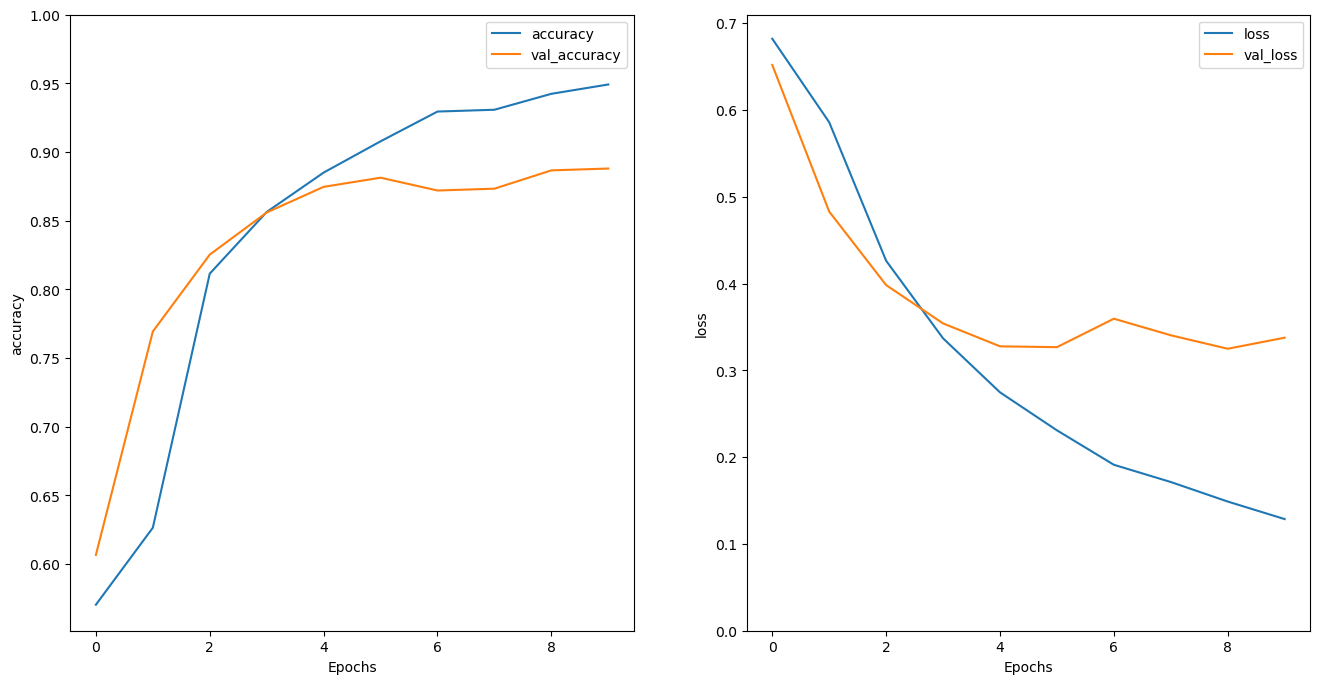

In [96]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [114]:
model.save("./models/model0_proto0_230819.keras", save_format="tf")

NotImplementedError: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7ff5704c4670>]

### Stack two LSTM layers

In [104]:
model1 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [105]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, None, 64)          320000    
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                      

In [106]:
model1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               optimizer=tf.keras.optimizers.Adam(1e-4),
               metrics=['accuracy'])

In [107]:
history1 = model1.fit(train_dataset0, epochs=10,
                      validation_data=valid_dataset0,
                      validation_steps=30)

Epoch 1/10


2023-08-19 11:15:24.053026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-08-19 11:15:26.832450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-08-19 11:15:47.433405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ign

183/183 [==============================] - 130s 402ms/step - loss: 0.6837 - accuracy: 0.5704 - val_loss: 0.6569 - val_accuracy: 0.6067
Epoch 2/10
183/183 [==============================] - 33s 182ms/step - loss: 0.5882 - accuracy: 0.6339 - val_loss: 0.4843 - val_accuracy: 0.7853
Epoch 3/10
183/183 [==============================] - 37s 197ms/step - loss: 0.4295 - accuracy: 0.8117 - val_loss: 0.4014 - val_accuracy: 0.8440
Epoch 4/10
183/183 [==============================] - 35s 193ms/step - loss: 0.3411 - accuracy: 0.8623 - val_loss: 0.3490 - val_accuracy: 0.8627
Epoch 5/10
183/183 [==============================] - 36s 196ms/step - loss: 0.2797 - accuracy: 0.8929 - val_loss: 0.3384 - val_accuracy: 0.8560
Epoch 6/10
183/183 [==============================] - 36s 193ms/step - loss: 0.2321 - accuracy: 0.9133 - val_loss: 0.3221 - val_accuracy: 0.8827
Epoch 7/10
183/183 [==============================] - 34s 188ms/step - loss: 0.1975 - accuracy: 0.9247 - val_loss: 0.3218 - val_accuracy: 0.

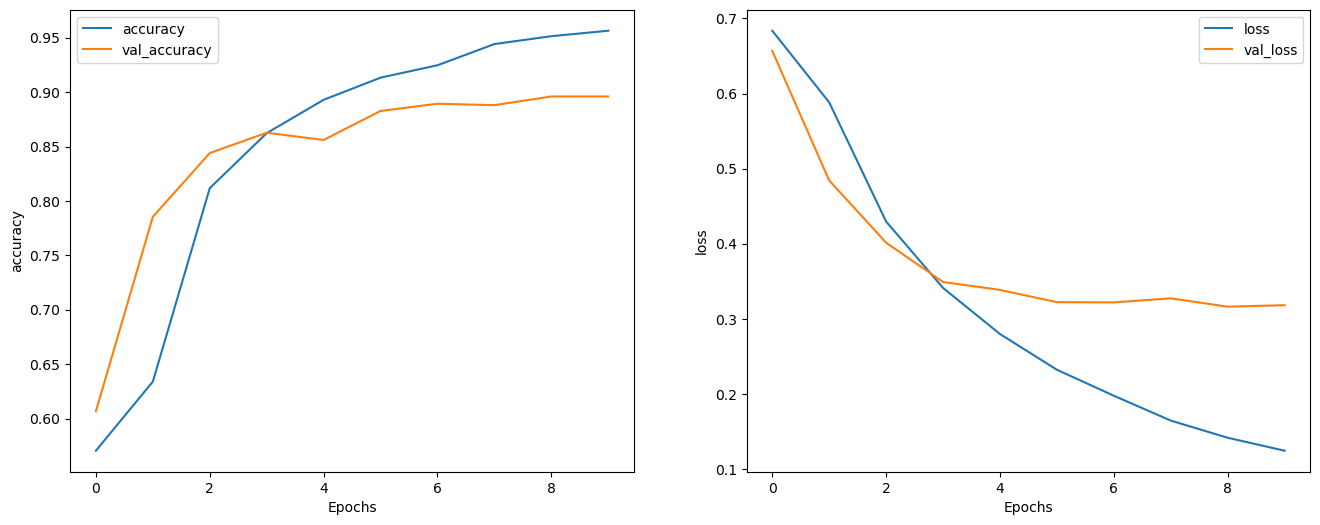

In [108]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history1, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history1, 'loss')